# Protected Areas

An area chart displaying the proportion of marine area that is protected by country or territory over time. The total marine area includes shared marine areas and any overseas territories.<br>

Note that the country/territory widget is a parameterized widget; the specification passed to the API will not be renderable without the geostore identifier being inserted. 


*Author: Rachel Thoms
<br>Created: 08 24 2021
<br>Environment: jupyterlab*

## Style

- Vega chart
- Chart type: area (country/territory) and stacked area (global) chart
- Value: Proportion (country/territory) or area in km<sup>2</sup> (global) of marine area that is protected

## Data

- Underlying data: [ocn_023_rw0_marine_protection](https://resourcewatch.carto.com/u/wri-rw/dataset/ocn_023_rw0_marine_protection_edit))
- Source: [OECD](https://data.oecd.org/biodiver/protected-areas.htm) (from the WDPA)

## Preparation

### Aliasing and Inserting Data

#### Queries

not inserted into master table

### Vega

In [4]:
import json
from vega import Vega
from IPython.display import display

In [5]:
def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

In [6]:
widget_width = 500
widget_height = 200

## Visualization

### Queries

#### Testing version

```gadm.geostore_prod ILIKE 'f4599aaeedacb9e6ddca177a93795e4c'``` used as stand-in for parameterized ```{{geostore_env}}='{{geostore_id}}'``` in production version

Global level (no parameterization)

```sql
SELECT gadm.gid_0, country, year AS date, value 
    FROM 
    (SELECT iso, country, year, value 
        FROM ocn_023_rw1_marine_protection_edit 
    UNION 
    SELECT 'GLB' AS iso, 'National waters' as country, year, value 
        FROM ocn_023_rw1_marine_protection_edit 
        WHERE iso='WLD' AND measure = 'Square kilometers' 
    UNION 
    SELECT 'GLB' AS iso, country, year, value 
        FROM ocn_023_rw1_marine_protection_edit 
        WHERE iso='ABNJ' AND measure = 'Square kilometers') AS data 
LEFT OUTER JOIN gadm36_0 gadm ON data.iso = gadm.gid_0 
    WHERE gadm.gid_0= 'GLB' AND country != 'Global' 
ORDER BY date ASC, name_0 ASC
```

Country/territory level

```sql
SELECT gadm.gid_0, country, year AS date, value 
FROM ocn_023_rw1_marine_protection_edit data 
LEFT OUTER JOIN gadm36_0 gadm ON data.iso = gadm.gid_0 
WHERE gadm.geostore_prod= 'f4599aaeedacb9e6ddca177a93795e4c' AND measure = 'Percent of total land/EEZ area' 
ORDER BY date ASC, name_0 ASC
```

#### Parameterized version

Global level (no parameterization; see above)

Country/territory level

```sql
SELECT gadm.gid_0, country, year AS date, value 
FROM ocn_023_rw1_marine_protection_edit data 
LEFT OUTER JOIN gadm36_0 gadm ON data.iso = gadm.gid_0 
WHERE gadm.{{geostore_env}}= '{{geostore_id}}' AND measure = 'Percent of total land/EEZ area' 
ORDER BY date ASC, name_0 ASC
```

## Resource Watch Widget Config

### Country/ Territory

In [9]:
spec=json.loads("""{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "padding": 5,
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q= SELECT gadm.gid_0, country, year AS date, value FROM ocn_023_rw1_marine_protection_edit data LEFT OUTER JOIN gadm36_0 gadm ON data.iso = gadm.gid_0 WHERE gadm.{{geostore_env}}= '{{geostore_id}}' AND measure = 'Percent of total land/EEZ area' ORDER BY date ASC, name_0 ASC",
      "format": {"type": "json", "property": "rows"}},
      {"name": "maximum",
    "source": "table",
    "transform": [{"type": "collect", "sort": {"field": "value","order": "descending"}}
  ]},
      {"name": "mpa",
      "source": "table",
      "transform": [ {
          "type":"formula",
          "expr": "'30%'",
          "as": "goal"
        },
        {
          "type":"formula",
          "expr": "datum.value/100",
          "as": "value"
        },
        {
          "type": "stack",
          "groupby": ["date"],
          "sort": {"field": "country"},
          "field": "value"
        },
        {"type": "formula",
        "expr": "datum.y0 + datum.y1",
        "as": "total"},
        {"type": "collect", "sort": {"field": ["date","country"],"order": ["ascending", "ascending"]}}
      ]
    },
    {
      "name": "highlightedPoint",
      "source": "mpa",
      "transform": [
        {
          "type": "filter",
          "expr": "(point_hover && point_hover.datum.date === datum.date) "
        }
      ]
    }],
  "signals": [
    {
      "name": "active_country",
      "value": "",
      "on": [
        {"events": "*:mouseover", "update": "datum.datum.country"},
        {"events": "*:mouseout", "update": "null"}
      ]
    },
    {
      "name": "point_hover",
      "value": null,
      "on": [
        {"events": "@points_voronoi:mouseover", "update": "datum"},
        {"events": "@points_voronoi:mouseout", "update": "null"}
      ]
    },
    {"name": "gid", "update": "data('mpa')[0]['gid_0']"},
    {"name": "max", "update": "data('maximum')[0]['value']/100"}
  ],
  "scales": [
    {
      "name": "x",
      "type": "point",
      "range": "width",
      "domain": {"data": "mpa", "field": "date"}
    },
    {
      "name": "y",
      "type": "linear",
      "range": "height",
      "nice": true,
      "zero": true,
      "domain": {"data": "mpa", "field": "value"},
      "domainMax": {"signal": "gid === 'GLB' ? 0.30 : max < 0.80 ? max + 0.10 : 1"}
    },
    {
      "name": "color",
      "type": "ordinal",
      "range": ["#005c7e"],
      "domain": {"data": "mpa", "field": "country"}
    }
  ],
  "axes": [
    {
      "orient": "bottom",
      "scale": "x",
      "labelBaseline": "middle",
      "labelOverlap": true,
      "labelFontSize": 10
    },
    {
      "orient": "left",
      "scale": "y",
      "labelBaseline": "middle",
      "labelAlign": "right",
      "labelPadding": 3,
      "grid": true,
      "gridOpacity": 0.1,
      "labelFontSize": 10,
      "format": "%"
    }
  ],
  "marks": [
    {
      "type": "group",
      "from": {"facet": {"name": "series", "data": "mpa", "groupby": "country"}},
      "marks": [
        {
          "type": "area",
          "from": {"data": "series"},
          "encode": {
            "enter": {
              "x": {"scale": "x", "field": "date"},
              "y": {"scale": "y", "field": "y0"},
              "y2": {"scale": "y","field": "y1"},
              "fill": {"scale": "color", "field": "country"},
              "fillOpacity": {"value": 0.8}
            },
            "update": {
              "interpolate": {"value": "monotone"},
              "fillOpacity": {"signal": "datum.country == active_country ? 0.85 : 0.8"}
            }
          }
        },
        {
          "type": "line",
          "from": {"data": "series"},
          "encode": {
            "enter": {
              "x": {"scale": "x", "field": "date"},
              "y": {"scale": "y", "field": "y1"},
              "stroke": {"scale": "color", "field": "country"},
              "strokeWidth": {"value": 2}
            },
            "update": {
              "interpolate": {"value": "monotone"},
              "strokeOpacity": {"signal": "datum.country == active_country ? 1 : 0.0"}
            }
          }
        },
        {
          "name": "points",
          "type": "symbol",
          "from": {"data": "mpa"},
          "encode": {
            "update": {
              "x": {"scale": "x", "field": "date"},
              "y": {"scale": "y", "field": "y1"},
              "size": {"value": 30},
              "shape": {"value": "circle"},
              "strokeWidth": {"value": 2},
              "stroke": {"scale": "color", "field": "country"},
              "fill": [{"test": "datum.country == active_country", "value": "white"},{"value":"transparent"}],
              "strokeOpacity": {"signal": "datum.country == active_country ? 1 : 0.0"}
            }
          }
        },
        {
          "name": "points_voronoi",
          "type": "path",
          "from": {"data": "points"},
          "encode": {
            "update": {
              "fill": {"value": "transparent"},
              "strokeWidth": {"value": 0.35},
              "stroke": {"value": "transparent"},
              "strokeOpacity": {"value": 0.2},
              "isVoronoi": {"value": true}
            }
          },
          "transform": [
            {
              "type": "voronoi",
              "x": "datum.x",
              "y": "datum.y",
              "extent": {"signal": "[[0, scale('y', max)],[width, height]]"}
            }
          ]
        },
        {
          "from": {"data": "highlightedPoint"},
          "type": "symbol",
          "interactive": false,
          "encode": {
            "update": {
              "x": {"scale": "x", "field": "date"},
              "y": {"scale": "y", "field": "y1"},
              "stroke": [{"test": "datum.country == active_country", "scale": "color", "field": "country"},{"value":"transparent"}],
              "strokeWidth": {"value": 1},
              "fill": [{"test": "datum.country == active_country", "scale": "color", "field": "country"},{"value":"transparent"}],
              "size": {"value":25},
              "fillOpacity": {"value": 1}
            }
          }
        }
      ]
    }
  ],
    "interaction_config": [
    {
      "name": "tooltip",
      "config": {
        "fields": [
          {
            "column": "datum.country",
            "property": "Country",
            "type": "text",
            "format": ""
          },
          {
            "column": "datum.date",
            "property": "Year",
            "type": "text",
            "format": ""
          },
          {
            "column": "datum.value",
            "property": "Proportion Protected",
            "type": "number",
            "format": ".1%"
          }
        ]
      }
    }
  ]
}""")

Parameterize the widget to view it in the notebook. A few parameters can also be adjusted for improved display.

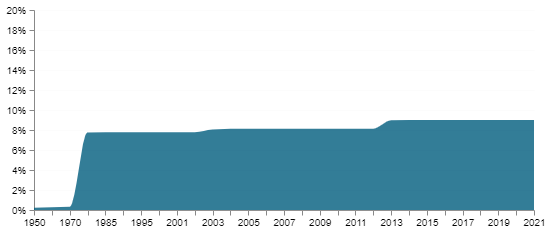

In [11]:
vega_view=dict(spec)
vega_view['height'] = widget_height
vega_view['width'] = widget_width
vega_view['data'][0]['url']= vega_view['data'][0]['url'].replace('{{geostore_env}}','geostore_prod')
vega_view['data'][0]['url'] = vega_view['data'][0]['url'].replace('{{geostore_id}}','ca5bfde08587530e76c17fe48362a01d')
vega_view['axes'][0]['labelBaseline']= "top"
Vega(vega_view)

[Open the Chart in the Vega Editor](https://vega.github.io/editor/#/url/vega/N4IgJAzgxgFgpgWwIYgFwhgF0wBwqgegIDc4BzJAOjIEtMYBXAI0poHsDp5kTykSArJQBWENgDsQAGhAB3GgBN6aAQAZVM+DTJY0AJnUycSBQpriyKmQqSYUqANqhxSBHDQg7TADbuZDACdvDyxcfCJZAJoAWgDZSigkAMw2BLYEAiQcGhI9TgBHbwB+fIBeAAIAZQBRABlqgGEAFXKKBQRqRQB9DXKoNgZxTACATylykbgk8oBBSvKbTDhx4iRvBjhygDEAJQB5AFlytihxHr0AZi64gEYu5CjxOC6cALYlqEx2M7gzTAXbEhyvUti09gBVJrVHblABSewAkgA5VomBAXABsPVR7XKexRiyoNDE5QqbQ6tAU2IA6gAJaHVHEU7qqCoAcgAQjsZmzZkiACLlNxICCBTbsgAKcACUDgQ2OADNyik7N5yt4kOIFARqtUAFrlJJTXl7Hb86HlDkATQBS1mlQa4xcbmxcwa0hACrYAWQmDQoEwIxw7nQogkHtebGDyRGHjesggIAAvkmpM5XCGQMgAB40BAMBAesSBWUeLy+D3DTUQL0+tBOTxBzP9by+T5F71+1CgBU0ODeBQeVbrPwgb0KaUeCfQOVmCzJpMAXVT6bcHgQxg7Jcz5dHVfENe9hccAabHlr+Y1Hrg2deHjZF1UAFI2R6RR4yGw1sm043g+ejwYK8ZBvO90EWAtKGHDYCBudQ30TdBoPcFc-0zCA7CgABrD0yDeBgcCYWNHBARZ3EXGQxGSf1PT7AcPH6QZhljVNaP7QckLWDYf1Pf90AvICUBA28AinWxIJGVRygAaltCSbgQst3m-VDAz4kAWzbP1KM7Gje3Y+tSNsUdGKGUYQAoscAgnUSSJFWUtXMSwZHs2cnIslNl1-Z1MxgbQYG8fylgUCU2HMbSQGLGVMw3ITPACasL3rXjM17bwllE4SwJAAAKHAwqGLoYDYUgAnKAAycryny8KipK6VKAgjoyNJUoKiaxrjIASnKZNl0siBtBcbxEIbHyPCQT4aFILpTOYj1kI8D1wxPEA4FIIZEJAAAqVAEAGCA4HqzKQAIsixMwSCOrm8zUPWuVMC23b9oYQ6Bgis7jI8cQgOCJdUPG9AasK4rSoWriQx+1sZBWht7s2jwAAFgcerpiG9CQwr2g6jrB-wcHO8DxMLO6NsepGUYgNGMfELGXrehgPoJr70Chv6vNXTNKQ9T6lgupAcrZWK2S6hxVEXBw2UpHo2UXHiQEBrMkGzHnmb5om7EFnM8wLEWxYltlkNl2D4KXSjEl8UbOY8FWZDUzMUY9BKLEzeQlBgD0FHSJBzBowl103GR9PojWUIBjMPFjO2z3QQKniSJ3NTIXy4CCj1xBoUtUGGDYZAAL2lNg0Bz5ZSO933uyMuwA7i4OOJARbWK95BzAOZWaMGshho-RRWvZABxWoOV5IpylUShH3KVAhWV8oAB4x8oAAOKTR5zGTF7gqfygUlNvIj9AW29SsY6sudvxkZ3k8MgBidQBCgAB2cjrHLyRK-99BYo9OuGIGMyWJmxAMrOAVsrJ9iGB4Jg7wUiFnNmsTMtsQAaiYP2DkIp+zmB3FGD0KD+x7FKhqHAxcAi52QUgVB3gtgSEwJUGgBc0BwVQt6CBXZkFwAVBFaACDI64IoWgjBccYqKAUBWGQeDvAzECl3OMadxH8O8BKEwc5LCoAuDIPCigSFkM0QoPYxgoB0GIuPG48jKHUKGHQhhqA4JByPLYDwT4+oyAeFhMB9sPz4WIUHN4x4eyTTgF2a26BDpRFAZ7QENdcJeKIn-Jit1WKuPcafI0tdfF+0iSE6UfZEysTlP0CcNEHqTkrirSu3CKzoCQb-UOP4QDEVABUzMUc2Ih3qaoOpIw9Adwts0n+dF64jF3kHGgrYek8MPmwbwx8RkGUmfEliIzWz6MmkYmii1UDjyXnvU6asQygHCtKfKGp1agA2VmTGKQnh1LSt4FZhjAwdyGt+DWkEbojFaoaKaM13nlFHlsgQ28tkLj3ilDwQif7pI-pkyK2Twl5PEAU-Za0hglNAGUxpvSbb9LmVXFCMgGmRSxegFpNT6nDMisMNgWFkVNL-tMk6ZL3l1Iwm8Gl1JFDKErhsvQOzebIsOQEY5LMzkQ3XJciQ+LKVsrgPctZ5TnnBFeR0X5bUvlfB+f-Zifyd5AsoB0lMoKFYHxAJTE+6kIAjAQNA4IPj0gZOrl-TcCKkU0X5TRDFRKJkgGqQMi6UrCV0pJTitpQyWX0ORRsx8rEIAwCyJGsVh8aAygrDGql7LOUe25Ym3llF020uJRpKZMzWn12ZaxW5yVPCgLYddLVoxPmTQ1c8ZlMhzmyD8nzVC5z9wQGMAEB6zjpXUtlQY+VjTFUXTefWj5aqm3TRbTOnVNw9UGsNfvNcQMCqo3Rm8WmNBzUO1sB7O1fiq72FNdu3JIFEVsEKZXd1ldK3ZpHGWZ2fajSQLTTKjl7t1mJvHhcAQ36R3-tfegXt-bB0gZpXKx5L7uKbMoLmkAxIABqNMwpgcQyXdd8VEpHirR4pCmGD0yDKVXSCSDiKUY6C0m8SxIEKq7i8kADgxbjCaYLEYbJxg5i6hRBwbt6DjC0DoTAi45aeVQgqKFoBP4YH8tIrAvxQrhTqcRyKVqbUekFfO0gaAFRrEOje11D69kevGZUn1Ib67nVYoGwtpK-Ukopay0Dq0lgYSnSqpdc7vmLoWUWQtR9GUuaLUF7tib8MHig1+ga+bf1ctFeBm4FbRlKobF52txM0gLMbQF2aM7gvetC7ZuJAD5Y9vfXFv0QDBrWJS4hvQwGll3LHfBprIY0uGv6jIPTU0JBFfEL2VRY0TUpCmV8bxRaRvaD0gMsBLYCzv1o3lyrRg3jRngyABoxXo7qSWNmCKF4HHoHlsthAq2OrnU21GaUO2rRTBOppo7J37FsIu1MlbPmoJiru9tmjEotudm+OUYH7w4CfF+Ie76BZUGMo+x4SgNwnH-X+kAA)

### Global Chart

In [12]:
spec=json.loads("""{
  "schema": "https://vega.github.io/schema/vega/v5.json",
  "padding": 5,
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q= SELECT gadm.gid_0, country, year AS date, value FROM (SELECT iso, country, year, value FROM ocn_023_rw1_marine_protection_edit UNION SELECT 'GLB' AS iso, 'National waters' as country, year, value FROM ocn_023_rw1_marine_protection_edit WHERE iso='WLD' AND measure = 'Square kilometers' UNION SELECT 'GLB' AS iso, country, year, value FROM ocn_023_rw1_marine_protection_edit WHERE iso='ABNJ' AND measure = 'Square kilometers') AS data LEFT OUTER JOIN gadm36_0 gadm ON data.iso = gadm.gid_0 WHERE gadm.gid_0= 'GLB' AND country != 'Global' ORDER BY date ASC, name_0 ASC",
      "format": {
        "type": "json",
        "property": "rows"
      }
    },
    {
      "name": "maximum",
      "source": "table",
      "transform": [
        {
          "type": "collect",
          "sort": {
            "field": "value",
            "order": "descending"
          }
        }
      ]
    },
    {
      "name": "mpa",
      "source": "table",
      "transform": [
        {
          "type": "formula",
          "expr": "'30%'",
          "as": "goal"
        },
        {
          "type": "formula",
          "expr": "'108,650,000 km²'",
          "as": "goal_area"
        },
        {
          "type": "stack",
          "groupby": [
            "date"
          ],
          "sort": {
            "field": "country"
          },
          "field": "value"
        },
        {
          "type": "formula",
          "expr": "datum.y0 + datum.y1",
          "as": "total"
        },
        {
          "type": "collect",
          "sort": {
            "field": [
              "date",
              "country"
            ],
            "order": [
              "ascending",
              "ascending"
            ]
          }
        }
      ]
    },
    {
      "name": "highlightedPoint",
      "source": "mpa",
      "transform": [
        {
          "type": "filter",
          "expr": "(point_hover && point_hover.datum.date === datum.date) "
        }
      ]
    }
  ],
  "signals": [
    {
      "name": "active_country",
      "value": "",
      "on": [
        {
          "events": "*:mouseover",
          "update": "datum.datum.country"
        },
        {
          "events": "*:mouseout",
          "update": "null"
        }
      ]
    },
    {
      "name": "point_hover",
      "value": null,
      "on": [
        {
          "events": "@points_voronoi:mouseover",
          "update": "datum"
        },
        {
          "events": "@points_voronoi:mouseout",
          "update": "null"
        }
      ]
    },
    {
      "name": "gid",
      "update": "data('mpa')[0]['gid_0']"
    },
    {
      "name": "max",
      "update": "data('maximum')[0]['value']*3/2"
    }
  ],
  "scales": [
    {
      "name": "x",
      "type": "point",
      "range": "width",
      "domain": {
        "data": "mpa",
        "field": "date"
      }
    },
    {
      "name": "y",
      "type": "linear",
      "range": "height",
      "nice": true,
      "zero": true,
      "domain": {
        "data": "mpa",
        "field": "value"
      },
      "domainMax": 108654490
    },
    {
      "name": "colors",
      "type": "ordinal",
      "range": [
        "#FFAE00",
        "#5079AF"
      ],
      "domain": {
        "data": "mpa",
        "field": "country"
      }
    },
    {
      "name": "goal",
      "type": "ordinal",
      "range": [
        "gold"
      ],
      "domain": [
        "Post-2020 Global Biodiversity Framework target"
      ]
    }
  ],
  "axes": [
    {
      "orient": "bottom",
      "scale": "x",
      "labelBaseline": "middle",
      "labelOverlap": true,
      "labelFontSize": 10
    },
    {
      "orient": "left",
      "scale": "y",
      "labelBaseline": "middle",
      "labelAlign": "right",
      "labelPadding": 3,
      "grid": true,
      "gridOpacity": 0.1,
      "labelFontSize": 10,
      "format": "~s",
      "title": "Protected area (km²)",
      "titleFont": "Lato"
    }
  ],
  "marks": [
    {
      "type": "group",
      "from": {
        "facet": {
          "name": "series",
          "data": "mpa",
          "groupby": "country"
        }
      },
      "marks": [
        {
          "type": "area",
          "from": {
            "data": "series"
          },
          "encode": {
            "enter": {
              "x": {
                "scale": "x",
                "field": "date"
              },
              "y": {
                "scale": "y",
                "field": "y0"
              },
              "y2": {
                "scale": "y",
                "field": "y1"
              },
              "fill": {
                "scale": "colors",
                "field": "country"
              },
              "fillOpacity": {
                "value": 0.8
              }
            },
            "update": {
              "interpolate": {
                "value": "monotone"
              },
              "fillOpacity": {
                "signal": "datum.country == active_country ? 0.85 : 0.8"
              }
            }
          }
        },
        {
          "type": "line",
          "from": {
            "data": "series"
          },
          "encode": {
            "enter": {
              "x": {
                "scale": "x",
                "field": "date"
              },
              "y": {
                "scale": "y",
                "field": "y1"
              },
              "stroke": {
                "scale": "colors",
                "field": "country"
              },
              "strokeWidth": {
                "value": 2
              }
            },
            "update": {
              "interpolate": {
                "value": "monotone"
              },
              "strokeOpacity": {
                "signal": "datum.country == active_country ? 1 : 0.0"
              }
            }
          }
        },
        {
          "name": "points",
          "type": "symbol",
          "from": {
            "data": "mpa"
          },
          "encode": {
            "update": {
              "x": {
                "scale": "x",
                "field": "date"
              },
              "y": {
                "scale": "y",
                "field": "y1"
              },
              "size": {
                "value": 30
              },
              "shape": {
                "value": "circle"
              },
              "strokeWidth": {
                "value": 2
              },
              "stroke": {
                "scale": {
                  "signal": "(datum.gid_0=== 'GLB' ? 'colors' : 'color')"
                },
                "field": "country"
              },
              "fill": [
                {
                  "test": "datum.country == active_country",
                  "value": "white"
                },
                {
                  "value": "transparent"
                }
              ],
              "strokeOpacity": {
                "signal": "datum.country == active_country ? 1 : 0.0"
              }
            }
          }
        },
        {
          "name": "points_voronoi",
          "type": "path",
          "from": {
            "data": "points"
          },
          "encode": {
            "update": {
              "fill": {
                "value": "transparent"
              },
              "strokeWidth": {
                "value": 0.35
              },
              "stroke": {
                "value": "transparent"
              },
              "strokeOpacity": {
                "value": 0.2
              },
              "isVoronoi": {
                "value": true
              }
            }
          },
          "transform": [
            {
              "type": "voronoi",
              "x": "datum.x",
              "y": "datum.y",
              "extent": {
                "signal": "[[0, scale('y', max)],[width, height]]"
              }
            }
          ]
        },
        {
          "from": {
            "data": "highlightedPoint"
          },
          "type": "symbol",
          "interactive": false,
          "encode": {
            "update": {
              "x": {
                "scale": "x",
                "field": "date"
              },
              "y": {
                "scale": "y",
                "field": "y1"
              },
              "stroke": [
                {
                  "test": "datum.country == active_country",
                  "scale": "colors",
                  "field": "country"
                },
                {
                  "value": "transparent"
                }
              ],
              "strokeWidth": {
                "value": 1
              },
              "fill": [
                {
                  "test": "datum.country == active_country",
                  "scale": "colors",
                  "field": "country"
                },
                {
                  "value": "transparent"
                }
              ],
              "size": {
                "value": 25
              },
              "fillOpacity": {
                "value": 1
              }
            }
          }
        }
      ]
    },
    {
      "name": "line",
      "from": {
        "data": "mpa"
      },
      "type": "line",
      "zindex": 1,
      "encode": {
        "enter": {
          "x": {
            "scale": "x",
            "field": "date"
          },
          "y": {
            "scale": "y",
            "value": 0.3
          },
          "strokeOpacity": [
            {
              "test": "gid === 'GLB'",
              "value": 1
            },
            {
              "value": 0
            }
          ],
          "stroke": {
            "value": "transparent"
          },
          "strokeWidth": {
            "value": 3
          },
          "strokeDash": {
            "value": [
              8,
              4
            ]
          }
        },
        "update": {
          "strokeOpacity": {
            "value": 1
          }
        },
        "hover": {
          "strokeOpacity": {
            "value": 0.5
          }
        }
      }
    },
    {
      "name": "goal",
      "from": {
        "data": "mpa"
      },
      "type": "line",
      "zindex": 1,
      "encode": {
        "enter": {
          "x": {
            "scale": "x",
            "field": "date"
          },
          "y": {
            "scale": "y",
            "value": 108654490
          },
          "stroke": {
            "value": "gold"
          },
          "strokeWidth": {
            "value": 2
          },
          "strokeDash": {
            "value": [
              8,
              4
            ]
          }
        },
        "update": {
          "strokeOpacity": {
            "value": 1
          }
        },
        "hover": {
          "strokeOpacity": {
            "value": 0.5
          }
        }
      }
    }
  ],
  "legends": [
    {
      "titleFont": "Lato",
      "labelFont": "Lato",
      "fill": "colors",
      "symbolOpacity": 0.7,
      "direction": "horizontal",
      "orient": "bottom"
    },
    {
      "fill": "goal",
      "zindex": 4,
      "orient": "bottom",
      "labelFont": "Lato",
      "encode": {
        "symbols": {
          "update": {
            "size": {
              "value": 80
            },
            "stroke": {
              "value": "gold"
            },
            "strokeDash": {
              "value": [
                4,
                2
              ]
            },
            "shape": {
              "value": "stroke"
            }
          }
        },
        "labels": {
          "interactive": true,
          "update": {
            "fill": {
              "value": "black"
            }
          },
          "hover": {
            "fill": {
              "value": "firebrick"
            }
          }
        }
      }
    }
  ],
  "interaction_config": [
    {
      "name": "tooltip",
      "config": {
        "fields": [
          {
            "column": "datum.country",
            "property": "Area",
            "type": "text",
            "format": ""
          },
          {
            "column": "datum.date",
            "property": "Year",
            "type": "text",
            "format": ""
          },
          {
            "column": "datum.value",
            "property": "Area protected (km²)",
            "type": "number",
            "format": ",.0f"
          },
          {
            "column": "goal",
            "property": "Post-2020 global biodiversity framework target",
            "type": "text",
            "format": ""
          },
          {
            "column": "goal_area",
            "property": "Area",
            "type": "text",
            "format": ""
          },
          {
            "column": "label",
            "property": "Area",
            "type": "text",
            "format": ""
          }
        ]
      }
    }
  ]
}""")

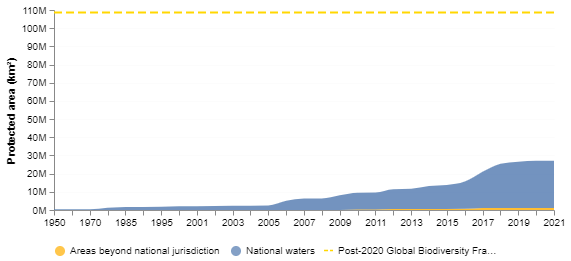

In [17]:
vega_view=dict(spec)
vega_view['height'] = widget_height
vega_view['width'] = widget_width
vega_view['axes'][0]['labelBaseline']= "top"
vega_view['axes'][1]['titleFont'] = 'Arial'
vega_view['legends'][0]['labelFont'] = 'Arial'
vega_view['legends'][1]['labelFont'] = 'Arial'
Vega(vega_view)

# Indicator

Proportion of the marine environment that is currently protected

## Country/territory

```sql
SELECT value FROM ocn_023_rw0_marine_protection_edit 
INNER JOIN gadm36_0 gadm ON iso = gadm.gid_0 
WHERE year = 2018 
AND gadm.{{geostore_env}} ILIKE '{{geostore_id}}'
```

- ```query```: [https://wri-rw.carto.com/api/v2/sql?q=SELECT ROUND(value) FROM ocn_023_rw0_marine_protection_edit INNER JOIN gadm36_0 gadm ON iso = gadm.gid_0 WHERE year = 2021 AND gadm.{{geostore_env}} ILIKE '{{geostore_id}}'](https://wri-rw.carto.com/api/v2/sql?q=SELECT%20ROUND(value)%20FROM%20ocn_023_rw0_marine_protection_edit%20INNER%20JOIN%20gadm36_0%20gadm%20ON%20iso%20=%20gadm.gid_0%20WHERE%20year%20=%202021%20AND%20gadm.gid_0%20ILIKE%20%27MEX%27)


## World

```sql
SELECT SUM(value) FROM ocn_023_rw0_marine_protection_edit  
WHERE year = 2021
AND iso IN ('ABNJ','WLD')
```

- ```query```: [https://wri-rw.carto.com/api/v2/sql?q=SELECT ROUND(SUM(value)) FROM ocn_023_rw0_marine_protection_edit WHERE year = 20 AND iso IN ('ABNJ','WLD')](https://wri-rw.carto.com/api/v2/sql?q=SELECT%20ROUND(SUM(value))%20FROM%20ocn_023_rw0_marine_protection_edit%20WHERE%20year%20=%202021%20AND%20iso%20IN%20(%27ABNJ%27,%27WLD%27))



## RW Backoffice

- parent dataset ocn.023 (unpublished)
    - dataset id ```40c8d7b8-36b6-4f07-8941-cc61dc62fc12```
- country widget id: ```92e5286e-b40a-4a6f-a3e5-84ac9b49d459```
    - [api widget](https://api.resourcewatch.org/v1/widget/92e5286e-b40a-4a6f-a3e5-84ac9b49d459?env=production)
    - [back office](https://resourcewatch.org/admin/data/widgets/92e5286e-b40a-4a6f-a3e5-84ac9b49d459/edit?dataset=40c8d7b8-36b6-4f07-8941-cc61dc62fc12)
- global widget id: ```c8107826-440d-4c14-8f12-3fb88449f730```
    - [api widget](https://api.resourcewatch.org/v1/widget/c8107826-440d-4c14-8f12-3fb88449f730?env=production)
